In [1]:
import pandas as pd

file_path = 'trace_files/W2K8.TPCC.10-19-2007.12-51-PM.trace-filtered-target'


In [2]:
df = pd.read_csv(file_path, sep=' ', header=None)

In [3]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.0,3247201,0.0,44,18446738027335882864,276996096,1536,3986,16,393283,3986,0.0,57
1,0.0,4247623,0.0,48,18446738027343121504,276996096,1536,4491,16,393283,4491,1000422.0,56
2,0.0,5288554,0.0,48,18446738027343121504,3201773568,8192,5322,17,393283,5322,1040931.0,55
3,0.0,5291785,0.0,48,18446738027343121504,3155169280,4096,3171,17,393283,3171,3231.0,54
4,0.0,5295691,0.0,48,18446738027343121504,3155156992,4096,3876,17,393283,3876,3906.0,53


In [4]:
df.columns = ['DiskWrite', 'timestamp', 'pid', 'ThreadID', 'IrpPtr', 'ByteOffset', 'IOSize', 'ElapsedTime', 'DiskNum', 'IrpFlags', 'DiskSvcTime', 'delta_time',	'target']

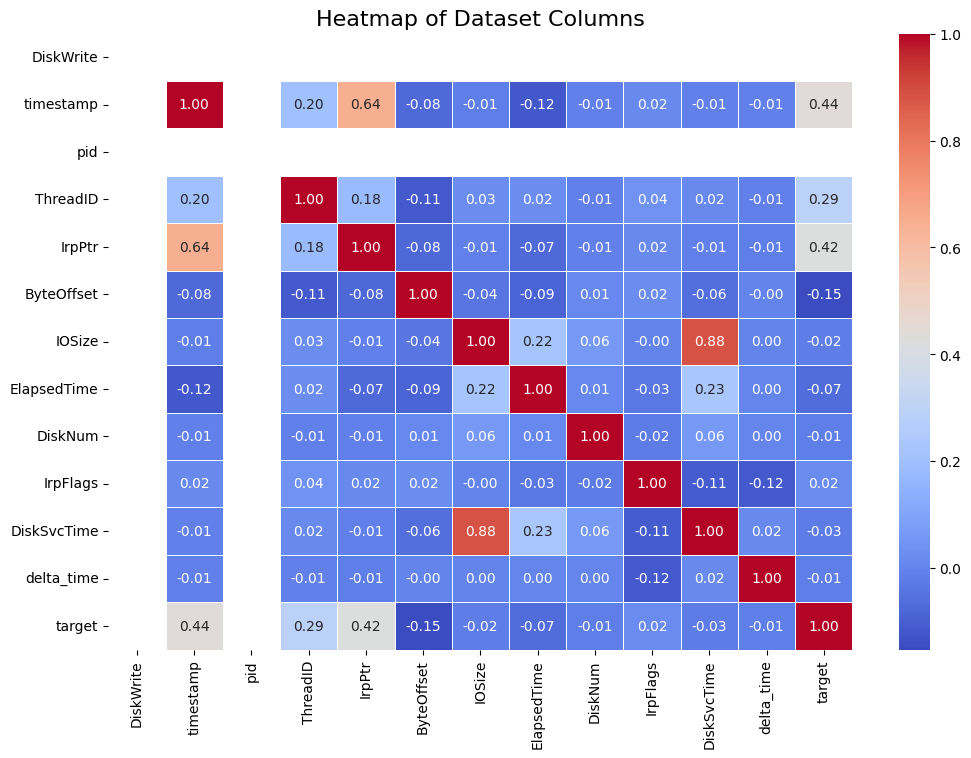

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt



# Data preprocessing (optional)
# Convert all columns to numerical types if necessary
df = df.apply(pd.to_numeric, errors='coerce')

# Fill missing values (optional)
df.fillna(0, inplace=True)

# Create a heatmap
plt.figure(figsize=(12, 8))  # Adjust size as needed
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Add title and labels
plt.title('Heatmap of Dataset Columns', fontsize=16)
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

features = ['IOSize', 'ElapsedTime', 'DiskSvcTime', 'delta_time', 'DiskNum']
target = ['ByteOffset']

# Normalize the data
scaler = MinMaxScaler()
df[features + target] = scaler.fit_transform(df[features + target])

# Create sequences for GRU
sequence_length = 10  # Adjust sequence length
X, y = [], []
for i in range(len(df) - sequence_length):
    X.append(df[features].iloc[i:i+sequence_length].values)
    y.append(df[target].iloc[i+sequence_length].values)

X = np.array(X)
y = np.array(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the GRU model
model = tf.keras.Sequential([
    tf.keras.layers.GRU(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dense(1)  # Output layer
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)


In [6]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

features = ['IOSize', 'ElapsedTime', 'DiskSvcTime', 'delta_time', 'DiskNum']
target = ['ByteOffset']

# Normalize the data
scaler = MinMaxScaler()
df[features + target] = scaler.fit_transform(df[features + target])

# Create a generator function
def data_generator(df, features, target, sequence_length, batch_size):
    total_samples = len(df) - sequence_length
    while True:
        for start_idx in range(0, total_samples, batch_size):
            end_idx = min(start_idx + batch_size, total_samples)
            X, y = [], []
            for i in range(start_idx, end_idx):
                X.append(df[features].iloc[i:i+sequence_length].values)
                y.append(df[target].iloc[i+sequence_length].values)
            yield np.array(X), np.array(y)

# Define sequence length and batch size
sequence_length = 10
batch_size = 32

# Split data into training and testing
train_size = int(len(df) * 0.8)
train_data = df[:train_size]
test_data = df[train_size:]

train_gen = data_generator(train_data, features, target, sequence_length, batch_size)
test_gen = data_generator(test_data, features, target, sequence_length, batch_size)

train_steps = (len(train_data) - sequence_length) // batch_size
test_steps = (len(test_data) - sequence_length) // batch_size


2024-12-23 05:56:01.725931: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-23 05:56:01.727272: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-23 05:56:01.752110: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-23 05:56:01.752628: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-23 05:56:02.222215: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [7]:
# Build the GRU model
model = tf.keras.Sequential([
    tf.keras.layers.GRU(64, return_sequences=True, input_shape=(sequence_length, len(features))),
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dense(1)  # Output layer
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [ ]:
# Train the model using the generator
history = model.fit(
    train_gen,
    steps_per_epoch=train_steps,
    validation_data=test_gen,
    validation_steps=test_steps,
    epochs=50
)

Epoch 1/50
 61488/147487 [===========>..................] - ETA: 39:36:33 - loss: 0.0128 - mae: 0.0914